# Pointer Network 구현 w/ Tensorflow

## 모델 형태

![image.png](attachment:image.png)



    ┏ --- 포인터
    |       ↑
    V        |
 인코더 => 디코더

In [1]:
# import module
import tensorflow as tf

import numpy as np
import os
import io
import time

#Define Token
START_ID = 0 #시퀀스 시작 토큰 ID
PAD_ID = 1   #시퀀스 공백 토큰 ID
END_ID = 2   #시퀀스 종결 토큰 ID

#Parameter
#입력 최대 길이
ENC_MAX_STEP = 10
#Label 최대 길이
DATA_MAX_OUTPUT = 4

DATA_PATH = "./data/convex_hull_5_test.txt"
PREFIX = "thermo"
#Label + End Token 최대 길이 
DEC_MAX_STEP = DATA_MAX_OUTPUT + 1 #max output lengths

BATCH_SIZE = 32
EPOCHS = 100
UNITS = 256
LEARNING_RATE = 0.001
BEAM_WIDTH = 4
OUTPUT_STD = None
DROPOUT_RATE = 0.0
#graident Clipping 파라미터
CLIPPING_VALUE = None
TRAIN_DATA_RATIO = 0.9

In [2]:
#데이터 로드 및 배치 생성기 유틸리티

def load_Dataset(data_path, input_step, output_step):
    inputs = []
    inputs_masks = []
    inputs_lengths = []
    labels = []
    labels_masks = []
    labels_lengths = []
    ENC_MAX_STEP = input_step
    DEC_MAX_STEP = output_step
    with open(data_path, 'r') as file:
        line = file.readline()
        while line :
            one_input = np.zeros([ENC_MAX_STEP, 2], dtype=np.float32)
            one_input_mask = np.zeros([ENC_MAX_STEP], dtype=int)
            line = line.split()
            length = 0
            i = 0
            while(line[i] != 'output'):
                one_input[length][0] = float(line[i])
                one_input[length][1] = float(line[i + 1])
                one_input_mask[length] = 1
                i += 2
                length += 1
            inputs.append(one_input)
            inputs_masks.append(one_input_mask)
            inputs_lengths.append(length)
            i += 1
            one_label = np.ones([DEC_MAX_STEP], dtype = int) * -1
            one_label_mask = np.zeros([DEC_MAX_STEP], dtype = int)
            length = 0
            while (i < len(line)):
                # 0 = start_id, 1 = pad_id, 2 = end_id
                one_label[length] = int(line[i])
                one_label_mask[length] = 1
                length += 1
                i += 1
            one_label[length] = 0  #end token
            one_label_mask[length] = 1
            length += 1

            labels.append(one_label)
            labels_masks.append(one_label_mask)
            labels_lengths.append(length)
            line = file.readline()

    inputs = np.stack(inputs)
    inputs_masks = np.stack(inputs_masks)
    inputs_lengths = np.array(inputs_lengths)
    labels = np.stack(labels)
    labels_masks = np.stack(labels_masks)
    labels_lengths = np.array(labels_lengths)

    return inputs, labels
    

class Batcher:
    def __init__(self, x, y, randomize = False):
        self.test_x = x
        self.test_y = y
        self.test_random_idx = None
        self.test_random = randomize
    
    def get_batch(self, batch_size):
        def shuffle_idx(x):
            if (self.test_random):
                np.random.shuffle(x)
        
        if (self.test_random_idx is None):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp = []
        targ = []
        while (batch_size > self.test_random_idx.shape[0]):
            inp.append(self.test_x[self.test_random_idx])
            targ.append(self.test_y[self.test_random_idx])
            batch_size -= self.test_random_idx.shape[0]
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp.append(self.test_x[self.test_random_idx[:batch_size]])
        targ.append(self.test_y[self.test_random_idx[:batch_size]])
        if (self.test_random_idx.shape[0] - batch_size == 0):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        else :
            self.test_random_idx = self.test_random_idx[batch_size:]
        inp = np.concatenate(inp, axis = 0)
        targ = np.concatenate(targ, axis = 0)
        return inp, targ
    def reset_random(self):
        self.test_random_idx = None
        

In [3]:
import os
import cv2

# 이미지 폴더 경로 지정
img_folder = "./image/"

# 저장할 폴더 경로 지정
save_folder = "./filtered_images/"

# 필터링 적용 함수
def apply_filters(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    median = cv2.medianBlur(gray, 3)
    return median

# 이미지 파일 목록 읽어오기
img_files = os.listdir(img_folder)

# 이미지 파일 하나씩 처리
for i, file_name in enumerate(img_files):
    # 이미지 파일 읽어오기
    img_path = os.path.join(img_folder, file_name)
    img = cv2.imread(img_path)

    # 필터 적용
    filtered_img = apply_filters(img)

    # 저장할 파일 경로 지정
    save_path = os.path.join(save_folder, file_name)

    # 이미지 파일 저장
    cv2.imwrite(save_path, filtered_img)

    print(f"Processed {i+1}/{len(img_files)} images.")

Processed 1/185 images.
Processed 2/185 images.
Processed 3/185 images.
Processed 4/185 images.
Processed 5/185 images.
Processed 6/185 images.
Processed 7/185 images.
Processed 8/185 images.
Processed 9/185 images.
Processed 10/185 images.
Processed 11/185 images.
Processed 12/185 images.
Processed 13/185 images.
Processed 14/185 images.
Processed 15/185 images.
Processed 16/185 images.
Processed 17/185 images.
Processed 18/185 images.
Processed 19/185 images.
Processed 20/185 images.
Processed 21/185 images.
Processed 22/185 images.
Processed 23/185 images.
Processed 24/185 images.
Processed 25/185 images.
Processed 26/185 images.
Processed 27/185 images.
Processed 28/185 images.
Processed 29/185 images.
Processed 30/185 images.
Processed 31/185 images.
Processed 32/185 images.
Processed 33/185 images.
Processed 34/185 images.
Processed 35/185 images.
Processed 36/185 images.
Processed 37/185 images.
Processed 38/185 images.
Processed 39/185 images.
Processed 40/185 images.
Processed

In [4]:
import os

dir_path = './filtered_images/'
file_list = [file_name for file_name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file_name))]

dataname = []
for file_name in file_list:
    data_name, extension = os.path.splitext(file_name)
    dataname.append(data_name)
    
len(dataname)
#dataname

185

In [5]:
#CNN - PTR 에 입력할 수 있는 형태로 변형

import PIL.Image as pilimg
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import scipy.ndimage as ndimage

data_x = []
data_y = []
original_imgs = []

for name in dataname:
  a = pilimg.open(f"./filtered_images/{name}.jpg")
  pix = np.array(a)
  #gray_pix = cv2.cvtColor(pix, cv2.COLOR_BGR2GRAY) #grayScale적용
  #median_pix = cv2.medianBlur(gray_pix, 3) #medianFilter적용

  with open(f"./221204/{name}.json", "r") as json_file:
    a_json = json.load(json_file)

  where_is_rec = None
  for i_sh in range(len(a_json["shapes"])):
    if a_json["shapes"][i_sh]["shape_type"] == "rectangle":
      where_is_rec = i_sh
      break;

  if where_is_rec is None: #예외처리
    print("rectangle이 아닌 데이터 타입 오류" + name)
    continue
  rec = np.array(a_json["shapes"][where_is_rec]["points"])
  rec = rec.astype(int)
  
  original_imgs.append(pix)
  print(name+"을 출력함") # 해당 부분이 출력이 걸린 거면 정상적으로 돌아가는 겁니다.
  new_pix = pix[rec[0, 1]:rec[1, 1], rec[0, 0]:rec[1, 0]]
  


  if new_pix is None or new_pix.size == 0:
        print(f"Error: Failed to crop image {name}")
        print("label image의 문제일 수 있습니다.")
        continue
        
  resized_pix = cv2.resize(new_pix, (150, 200))
  #출력
  #plt.imshow(resized_pix) 
  #plt.show()
  #print(resized_pix.shape)
  nums = []
  y = 4
  x = 1
  nums.append(resized_pix[y*40:(y+1)*40, x*50:(x+1)*50]) # 0번 키패드
  #plt.imshow(resized_pix[y*40:(y+1)*40, x*50:(x+1)*50])
  #plt.show() 
  for y in range(1, 4):
    for x in range(3):
       #출력
      #plt.imshow(resized_pix[y*40:(y+1)*40, x*50:(x+1)*50])
      #plt.show() 
      nums.append(resized_pix[y*40:(y+1)*40, x*50:(x+1)*50])
  nums = np.array(nums)
  
  tgt = []
  for c in name:
    tgt.append(int(c)+1)
  tgt.append(0)
  tgt = np.array(tgt)
  
  data_x.append(nums)
  data_y.append(tgt)
  
data_x = np.array(data_x)
data_x = (data_x / 255.0).astype(np.float32)
data_y = np.array(data_y)

original_imgs = np.array(original_imgs)

for i in range(2):
  print(f"data_x[{i}].shape:", data_x[i].shape) #(버튼 개수, 높이 ,너비, 채널)
  print(f"data_y[{i}]:", data_y[i])

0021을 출력함
0256을 출력함
0294을 출력함
0316을 출력함
0375을 출력함
0547을 출력함
0594을 출력함
0623을 출력함
0863을 출력함
0914을 출력함
1048을 출력함
1057을 출력함
1111을 출력함
1137을 출력함
1195을 출력함
1234을 출력함
1258을 출력함
1283을 출력함
1345을 출력함
1346을 출력함
1357을 출력함
1379을 출력함
1415을 출력함
1470을 출력함
1556을 출력함
1667을 출력함
1668을 출력함
1680을 출력함
1999을 출력함
2000을 출력함
2113을 출력함
2135을 출력함
2357을 출력함
2379을 출력함
2424을 출력함
2532을 출력함
2559을 출력함
2571을 출력함
2580을 출력함
2623을 출력함
2693을 출력함
2703을 출력함
2792을 출력함
2811을 출력함
2827을 출력함
2828을 출력함
2986을 출력함
3079을 출력함
3082을 출력함
3090을 출력함
3177을 출력함
3185을 출력함
3241을 출력함
3271을 출력함
3313을 출력함
3361을 출력함
3492을 출력함
3548을 출력함
3570을 출력함
3617을 출력함
3640을 출력함
3721을 출력함
3823을 출력함
3832을 출력함
3885을 출력함
3996을 출력함
4096을 출력함
4147을 출력함
4184을 출력함
4187을 출력함
4204을 출력함
4207을 출력함
4239을 출력함
4259을 출력함
4333을 출력함
4385을 출력함
4453을 출력함
4479을 출력함
4628을 출력함
4637을 출력함
4655을 출력함
4744을 출력함
4757을 출력함
4800을 출력함
4814을 출력함
4914을 출력함
5041을 출력함
5069을 출력함
5076을 출력함
5123을 출력함
5199을 출력함
5214을 출력함
5297을 출력함
5397을 출력함
5419을 출력함
5487을 출력함
5629을 출력함
5669을 출력함
5706을 출력함
5770을 출력함


In [6]:

#print(len(data_y))
#print(len(data_x))
print(data_x.shape)

(185, 10, 40, 50)


In [7]:
n_data = len(data_x)  # 데이터 개수 계산
print(n_data)
cut = np.zeros([n_data], dtype=bool)
cut[np.random.choice(n_data, 18, replace=False)] = True # 10개의 데이터를 random하게 validation data로 선택
train_inputs = data_x[~cut]
train_labels = data_y[~cut]
train_orig = original_imgs[~cut]

val_inputs   = data_x[cut]
val_labels   = data_y[cut]
val_orig = original_imgs[cut]


#train_inputs = np.expand_dims(train_inputs, axis=-1) 색상 채널 추가
print(train_inputs.shape)
print(val_inputs.shape)
STEPS_PER_EPOCH = train_inputs.shape[0]//BATCH_SIZE
print(STEPS_PER_EPOCH)
# 배열에서 0은 종결 토큰입니다. 따라서 각 인덱스에 -1를 해준 게 비밀번호 값
# 예: [5 3 1 5 0]은 비밀번호가 4 2 1 4입니다.

185
(167, 10, 40, 50)
(18, 10, 40, 50)
5


In [8]:
#증강
import PIL.Image as pilimg
import numpy as np
import json
import cv2

dataname = []
for file_name in file_list:
    data_name, extension = os.path.splitext(file_name)
    dataname.append(data_name)

data_x = []
data_y = []

shifts = [(0, 0),
         (2, 2), (2, -2), (-2, 2), (-2, -2),
         (8, 0), (8, 0), (0, 8), (0, -8),
         (4, 4), (4, -4), (-4, 4), (-4, -4),
         (12, 0), (-12, 0), (0, 12), (0, -12)]

rotates = [0, 2, -2, 5, -5, 10, -10, 15, -15]

for name in dataname:
    # Test 데이터 제외
    if name in [dataname[i] for i in np.where(cut)[0]]:
        continue
    try:
        a = pilimg.open(f"./filtered_images/{name}.jpg")
    except:
        a = pilimg.open(f"./filtered_images/{name}.png")
    pix = np.array(a)
    with open(f"./221204/{name}.json", "r") as json_file:
        a_json = json.load(json_file)

    where_is_rec = None
    for i_sh in range(len(a_json["shapes"])):
        if a_json["shapes"][i_sh]["shape_type"] == "rectangle":
            where_is_rec = i_sh
            break;
    rec = np.array(a_json["shapes"][where_is_rec]["points"])
    rec = rec.astype(int)

    for shift in shifts:
        dy, dx = shift
        for rotate in rotates:
            nums = []
            new_pix = pix[rec[0, 1]+dy:rec[1, 1]+dy, rec[0, 0]+dx:rec[1, 0]+dx]
            '''
            # Grayscale filter 적용
            gray_pix = cv2.cvtColor(new_pix, cv2.COLOR_BGR2GRAY)
            
            # Median filter 적용
            median_pix = cv2.medianBlur(gray_pix, 3)
            
            resized_pix = cv2.resize(median_pix, (150, 200))
            '''
            
            resized_pix = cv2.resize(new_pix,(150, 200))
            #plt.imshow(resized_pix)
            #plt.show()

            cx, cy = 25, 20
            M = cv2.getRotationMatrix2D((cx,cy), rotate, 1)
            y = 4
            x = 1
            npad = resized_pix[y*40:(y+1)*40, x*50:(x+1)*50]
            rotated = cv2.warpAffine(npad, M, (50, 40))
            #plt.imshow(rotated)
            plt.show()
            nums.append(rotated)
            for y in range(1, 4):
                for x in range(3):
                    npad = resized_pix[y*40:(y+1)*40, x*50:(x+1)*50]
                    rotated = cv2.warpAffine(npad, M, (50, 40))
                    #plt.imshow(rotated)
                    #plt.show()
                    nums.append(rotated)
            nums = np.array(nums)

            tgt = [int(c)+1 for c in name] + [0]
            tgt = np.array(tgt)

            data_x.append(nums)
            data_y.append(tgt)

            # 적용 후 nums 변수 삭제
            del nums

data_x = np.array(data_x)
data_x = (data_x / 255.0).astype(np.float32)
data_y = np.array(data_y)

original_imgs = np.array(original_imgs)

train_inputs = data_x
train_labels = data_y
train_orig = original_imgs

#rain_inputs = np.expand_dims(train_inputs, axis=-1)

print(train_inputs.shape)
print(data_y.shape)

(25551, 10, 40, 50)
(25551, 5)


In [9]:
class Batcher:
    def __init__(self, x, y, randomize = False):
        self.test_x = x
        self.test_y = y
        self.test_random_idx = None
        self.test_random = randomize
    
    def get_batch(self, batch_size):
        def shuffle_idx(x):
            if (self.test_random):
                np.random.shuffle(x)
        
        if (self.test_random_idx is None):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp = []
        targ = []
        while (batch_size > self.test_random_idx.shape[0]):
            inp.append(self.test_x[self.test_random_idx])
            targ.append(self.test_y[self.test_random_idx])
            batch_size -= self.test_random_idx.shape[0]
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp.append(self.test_x[self.test_random_idx[:batch_size]])
        targ.append(self.test_y[self.test_random_idx[:batch_size]])
        if (self.test_random_idx.shape[0] - batch_size == 0):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        else :
            self.test_random_idx = self.test_random_idx[batch_size:]
        inp = np.concatenate(inp, axis = 0)
        targ = np.concatenate(targ, axis = 0)
        return inp, targ
    def reset_random(self):
        self.test_random_idx = None
        
train_batcher = Batcher(train_inputs, train_labels, randomize=True)

inp, targ = train_batcher.get_batch(32)

print(inp.shape)
print(targ.shape)
train_batcher.reset_random()

(32, 10, 40, 50)
(32, 5)


# Encoder and Decoder (+ Attention)



### 인코더와 디코더는 기본적으로 LSTM 모델을 사용한다.

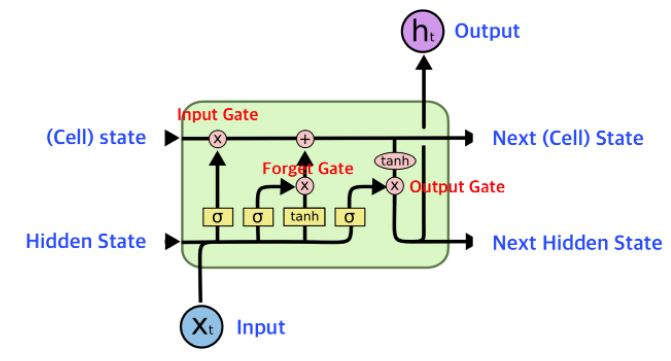

LSTM은 h와 c 두 개의 은닉 상태를 가진다.
* h: 단기 기억(이자 출력)
* c: 장기 기억


In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, enc_units, batch_sz):
        #매개변수 설명
        #enc_unit: RNN의 뉴런 개수
        #          LSTM을 사용하기 때문에 h, c 
        #          즉 2*enc_unit 개의 파라미터를 가지게 된다.
        #batch_sz: 배치 크기 디폴트값
        #          최초 Zero 상태 출력할 때 사용
        
        #부모 클래스(tf.keras.Model) 초기화 호출
        super(Encoder, self).__init__()
        #객체 변수 할당
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        
        #★★★★★★★★★★★★★★★★
        #CNN 추가 부분
        timeD = tf.keras.layers.TimeDistributed
        
        self.c1 = timeD(
           tf.keras.layers.Conv2D(1,
                                 (3, 3),
                                 padding="same",
                                 activation="relu",
                                 kernel_initializer="he_normal",
                                 input_shape=(10,40,50))
        )
        self.p1 = timeD(
          tf.keras.layers.MaxPooling2D((2, 2),
                                      strides=(2, 2))
        )
        
        self.c2 = timeD(
          tf.keras.layers.Conv2D(enc_units//2,
                                 (3, 3),
                                 padding="same",
                                 activation="relu",
                                 kernel_initializer="he_normal")
        )
        self.p2 = timeD(
                tf.keras.layers.MaxPooling2D((2, 2),
                                            strides=(2, 2))
        )
        self.c3 = timeD(
          tf.keras.layers.Conv2D(enc_units,
                                 (3, 3),
                                 padding="same",
                                 activation="relu",
                                 kernel_initializer="he_normal")
                       )
        self.p3 = timeD(
          tf.keras.layers.GlobalAveragePooling2D()
        )
        #★★★★★★★★★★★★★★★
        #RNN으로는 LSTM 사용 선언
        self.rnn = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(self.enc_units, activation = 'tanh'),
            return_sequences = True, 
            return_state = True)
    
    #객체를 함수처럼 호출하면 실제로 실행되는 메소드
    # output, state = encoder(x, hidden)
    def call(self, x, hidden):
        #x :     [batch_size, time_step, n_features]
        #hidden: rnn cell에 대응되는 state 차원
        
        #output: [batch_size, times_step, enc_unit]
        # state는 마지막 time step의 Encoder의 상태
        # LSTM을 사용한다면, state는 [h, c] 두 벡터 원소를 
        # 가진 리스트로 출력된다
        #h:      [batch_size, enc_unit]
        #c:      [batch_size, enc_unit]
        
        c = x
        c = self.c1(c)
        c = self.p1(c)
        c = self.c2(c)
        c = self.p2(c)
        c = self.c3(c)
        c = self.p3(c)
        
        output, *state = self.rnn(c, initial_state = hidden)
        return output, state

    #인코더의 최초 상태(zero state)를 반환하는 메소드
    #LSTM을 사용하기 때문에, 원소 두개의 리스트를 반환함
    def initialize_hidden_state(self, batch_size = None):
        #return zero state
        if (batch_size == None):
            return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))]
        else:
            return [tf.zeros((batch_size, self.enc_units)), tf.zeros((batch_size, self.enc_units))]

#BahdanauAttention을 변형한 Pointer layer
class Pointer(tf.keras.layers.Layer):
    def __init__(self, units, return_as_logits = True):
        # unit: Dense 계층의 뉴런 개수
        # return_as_logits: 마지막 pointer의 출력을
        #           소프트맥스를 통과한 확률(False)로 할 것인가
        #           스코어 값(True)으로 할 것인가.
        super(Pointer, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.return_as_logits = return_as_logits

    def call(self, query, keys):
        #query: (BATCH_SIZE, TIMESTEP, hidden_size) ((BATCH_SIZE, 1, hidden_size) at inference )
        #keys: (BATCH_SIZE, TABLESIZE, hidden_size), Table => End token + Encoder step
        
        time_step_length = query.shape[1]
        
         
        # enc_vec: (BATCH_SIZE, TABLESIZE, units)
        enc_vec = self.W1(keys)
        
        # enc_vec_with_time_axis: (BATCH_SIZE, TIMESTEP, TABLESIZE, units)
        enc_vec_with_time_axis = tf.tile(tf.expand_dims(enc_vec, 1), [1, time_step_length, 1, 1])
        
        #dec_vec: (BATCH_SIZE, TIMESTEP, units)
        dec_vec = self.W2(query)
        
        #dec_vec_for_broadcasting: (BATCH_SIZE, TIMESTEP, 1. units)
        dec_vec_for_broadcasting = tf.expand_dims(dec_vec, 2)
        
        
        #score: (BATCH_SIZE, TIMESTEP, TABLESIZE, 1)
        score = self.V(tf.nn.tanh(
            enc_vec_with_time_axis + dec_vec_for_broadcasting))
        
        
        if self.return_as_logits:
            return score
        
        # as Probablity
        # attention_weights: (BATCH_SIZE, TIMESTEP, TABLESIZE, 1)
        attention_weights = tf.nn.softmax(score, axis=2)

        return attention_weights

      
class Decoder(tf.keras.Model):
    def __init__(self, dec_units, batch_sz, return_as_logits = True):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        
        #★★★★★★★★★★★★★★
        timeD = tf.keras.layers.TimeDistributed
        
        self.c1 = timeD(
          tf.keras.layers.Conv2D(dec_units//4,
                                 (3, 3),
                                 padding="same",
                                 activation="relu",
                                 kernel_initializer="he_normal")
        )
        self.p1 = timeD(
          tf.keras.layers.MaxPooling2D((2, 2),
                                      strides=(2, 2))
        )
        
        self.c2 = timeD(
          tf.keras.layers.Conv2D(dec_units//2,
                                 (3, 3),
                                 padding="same",
                                 activation="relu",
                                 kernel_initializer="he_normal")
        )
        self.p2 = timeD(
                tf.keras.layers.MaxPooling2D((2, 2),
                                            strides=(2, 2))
        )
        self.c3 = timeD(
          tf.keras.layers.Conv2D(dec_units,
                                 (3, 3),
                                 padding="same",
                                 activation="relu",
                                 kernel_initializer="he_normal")
                       )
        self.p3 = timeD(
          tf.keras.layers.GlobalAveragePooling2D()
        )
        
        self.rnn = tf.keras.layers.RNN(
            tf.keras.layers.LSTMCell(self.dec_units, activation = 'tanh'),
            return_sequences = True, 
            return_state = True)
        #★★★★★★★★★★★★★★
        # used for attention
        self.pointer = Pointer(self.dec_units, return_as_logits = return_as_logits)

    def call(self, x, hidden, values):
        #values: (batch_size, TABLESIZE, hidden_size)
        
        #output: (batch_size, dec_max_step, hidden_size )
        
        c = x
        c = self.c1(c)
        c = self.p1(c)
        c = self.c2(c)
        c = self.p2(c)
        c = self.c3(c)
        c = self.p3(c)
        
        output, *state = self.rnn(c, initial_state = hidden)
        
        #score: (BATCH_SIZE, DEC_MAX_STEP, 1+ ENC_MAX_STEP, 1)
        score = self.pointer(output, values)

        return score, state

# Encoder-Decoder 결합한 전체 ptr-net

## self.end_token_outputs에 대하여

```python
if (output_std is None):
    # 0.0185 == output's std when unit = 256
    output_std = 0.0185 * np.sqrt(256 / unit)
self.end_token_outputs = tf.Variable(np.random.normal(0, output_std, [1, 1, unit]), dtype = np.float32)
```


Decoder의 Pointer는 매 스텝마다 인코더에 어떤 입력을 가리키는 방식과 같은 방식으로\
이 생성되고 있는 시퀀스가 "지금 끝났다" 라고 말할 수 있어야 한다.

그래서 우리는 Pointer가 우리가 임의로 정한 하나의 Key 값을 가리키게 되면\
Decoder가 이 시퀀스는 끝났음을 지시했다고 설계하고 싶은데\
그 Key 값을 self.end_token_outputs로 선언한 것이다.

이 값은 임의의 표준편차를 주고 정규분포로 정규화한 학습 가능한 파라미터로 두었지만...\
zero vector로 처리하고 학습이 불가능하게 하는 둥, 처리하는 방법은 다양한 듯 하다


![image.png](attachment:image.png)

위 그림의 빨간 화살표가 End token의 Key vector를 나타낸 것이다.

In [11]:
class PointerNetwork:
    def __init__(self, unit, batch_size,
                 learning_rate = 0.001,
                 output_std = None,
                 dropout_rate = 0.0):
        self.encoder = Encoder(unit, batch_size)
        self.decoder = Decoder(unit, batch_size, return_as_logits = True)
        #Loss Function에 사용할 함수로 Cross Entropy 사용
        self.loss_object = tf.keras.losses.CategoricalCrossentropy(
                                      from_logits=True, reduction='none') 
        #학습 Optimizer 설정. Adam 사용
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        #End token의 Key token 생성
        #make end token embedding for pointing
        if (output_std is None):
            # 0.0185 == output's std when unit = 256
            output_std = 0.0185 * np.sqrt(256 / unit)
        self.end_token_outputs = tf.Variable(np.random.normal(0, output_std, [1, 1, unit]), dtype = np.float32)
        
        #token 좌표 테이블
        #디코더의 매 스텝마다 출력이 나오면, 해당 출력에 해당하는 점의 좌표 값이 
        #다음 스텝으로 입력으로 들어가게 되는데
        #시작 토큰(0)이나 다른 토큰(1, 2)들이 나왔을 때, 다음 입력으로 들어갈 (x, y) 좌표 테이블이다.
        #임의로 설정 가능하며, (0 , 0)으로 설정함
        #token_table = [[begin_token, end_token, pad_token]]
        #begin_token = end_token = pad_token = (0, 0)
        #★★★★★
        #원래 token에 대응되는 좌표 값들이였는데, token에 대한 이미지 값으로 차원 맞춰줌
        self.token_table = tf.Variable(np.zeros([1, 3, 40, 50, 3]), dtype = np.float32)
        
        self.dropout_rate = dropout_rate
        
        #Checkpoint 파라미터 전달용 dict
        self.model = {}
        self.model['encoder'] = self.encoder
        self.model['decoder'] = self.decoder
        self.model['optimizer'] = self.optimizer
        self.model['end_token_outputs'] = self.end_token_outputs
        
    def get_model(self):
        return self.model
    
    #정답 real(정수값)와 스코어 pred(실수 점수)가 들어오면 두 값의 loss를 구함 
    def loss_function(self, real, pred):
        #real.shape = (BATCH_SIZE, DEC_MAX_STEP)
        #pred.shape = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP, 1)
        
        #real_onehot.shape = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP)
        real_onehot = tf.one_hot(real, pred.shape[-2], on_value = 1.0)
        
        #loss_ = (BATCH_SIZE, DEC_MAX_STEP)
        loss_ = self.loss_object(real_onehot, pred)
        
        #real(정답)에서 padding(-1)에 해당하는 부분은 제외함
        #mask = (BATCH_SIZE, DEC_MAX_STEP)
        mask = tf.math.logical_not(tf.math.equal(real, -1))
        
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_sum(loss_) / tf.reduce_sum(mask) , loss_, mask
    
    #Teacher forcing
    #학습의 용이를 위하여 이전 스텝의 정답(targ[t-1])을 이번 스텝의 입력으로 넣는 학습법
    def teacher_forcing_run(self, inp, targ):
        #inp:  [BATCH_SIZE, ENC_MAX_STEP, 2]
        #targ: [BATCH_SIZE, DEC_MAX_STEP]
      
        #local batch size
        local_bsz = inp.shape[0]
        
        #zero state
        enc_state = self.encoder.initialize_hidden_state(local_bsz) 
        
        #Encoder 출력 파트 
        #enc_output.shape = (BATCH_SIZE, ENC_MAX_STEP, hidden_size)
        enc_output, enc_state = self.encoder(inp, enc_state)
        
        #Dropout
        if self.dropout_rate != 0.0:
            enc_output = tf.nn.dropout(enc_output, rate = self.dropout_rate)
            #LSTM 대응
            if type(enc_state) == list:
                for i in range(len(enc_state)):
                    enc_state[i] = tf.nn.dropout(enc_state[i], rate = self.dropout_rate)
            #LSTM이 아닌 GLU같은거
            else:
                enc_state = tf.nn.dropout(enc_state, rate = self.dropout_rate )
        
        #enc_output with end token output
        # .shape = (BATCH_SIZE, 1 + ENC_MAX_STEP, hidden_size )
        enc_output = tf.concat([tf.tile(self.end_token_outputs, [local_bsz, 1, 1]),
                            enc_output], 1)
        
        # token table에 대한 자세한 설명은 __init__ 함수 참고
        #tiled_token_table = (BATCH_SIZE, 3, 2)
        tiled_token_table = tf.tile(self.token_table, [local_bsz, 1, 1, 1, 1])
        #enc_table = (BATCH_SIZE, 3 + ENC_MAX_STEP, 2)
        #[token_table | input_table]
        enc_table = tf.concat([tiled_token_table, inp], 1)

        #시작 입력 (시작 토큰)
        #dec_input = (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([START_ID] * local_bsz, 1)
        
        #teacher forcing 입력 설계
        #매 스텝의 입력은 다음과 같이 처리된다.
        #[start_token, first_label, ... last_label, pad_token, ...]
        
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP), 정수형
        dec_input = tf.concat([dec_input, tf.cast(targ[:, :-1] + END_ID, dtype=np.int32)], 1)
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP, 1)
        dec_input = tf.expand_dims(dec_input,-1)
        
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP, 2)
        #좌표 테이블로 부터 id에 대응되는 (x, y) 좌표를 얻어낸다.
        dec_input = tf.gather_nd(enc_table, dec_input, batch_dims=1)
        #predictions = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP, 1)
        #encoder => enc_state => decoder
        #                         ^
        #                      x ┚
        predictions, dec_state = self.decoder(dec_input, enc_state, enc_output)
        
        total_loss, losses, masks = self.loss_function(targ, predictions) 
        return predictions, total_loss, losses, masks
    
    #without teacher forcing
    def naive_run(self, inp, targ,
                  return_as_idx = False,
                  max_length = 99999,
                  FORCED_TO_MAKE_TRIANGLE = False,
                  **kwargs): 
        #local batch size
        local_bsz = inp.shape[0]
        #zero state
        enc_state = self.encoder.initialize_hidden_state(local_bsz) 
        #enc_output.shape = (BATCH_SIZE, ENC_MAX_STEP, hidden_size)
        enc_output, enc_state = self.encoder(inp, enc_state)
        #enc_output with end token output
        # .shape = (BATCH_SIZE, 1 + ENC_MAX_STEP, hidden_size )
        enc_output = tf.concat([tf.tile(self.end_token_outputs, [local_bsz, 1, 1]),
                            enc_output], 1)
        
        # token table에 대한 자세한 설명은 __init__ 함수 참고
        #tiled_token_table = (BATCH_SIZE, 3, 2)
        tiled_token_table = tf.tile(self.token_table, [local_bsz, 1, 1, 1, 1])
        #enc_table = (BATCH_SIZE, 3 + ENC_MAX_STEP, 2)
        #[token_table | input_table]
        enc_table = tf.concat([tiled_token_table, inp], 1)

        #dec_input = (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([START_ID] * local_bsz, 1)
        #encoder => state = > decoder
        dec_state = enc_state
        predictions = []
        predictions_idx = []
        losses = []
        total_loss = 0
        masks = []
        
        for t in range(0, min(targ.shape[1], max_length) ):
            #id - > (x, y)
            #dec_input = (BATCH_SIZE, 2)
            dec_input = tf.gather_nd(enc_table, dec_input, batch_dims=1)
            #dec_input = (BATCH_SIZE, time_axis = 1, 2)
            dec_input = tf.expand_dims(dec_input, 1)
            #predictions = (BATCH_SIZE, 1, 1 + ENC_MAX_STEP, 1)
            prediction, dec_state = self.decoder(dec_input, dec_state, enc_output)
            
            #loss = (BATCH_SIZE, 1)
            #mask = (BATCH_SIZE, 1)
            loss_sum, loss, mask = self.loss_function(targ[:, t:t+1], prediction)
            total_loss += loss_sum
            losses.append(loss)
            masks.append(mask)
            #predicted_idx.shape = (BATCH_SIZE, 1, 1)
            predicted_idx = tf.argmax(prediction, axis = 2)
            dec_input = predicted_idx[:, :, 0] + END_ID
            predictions_idx.append(predicted_idx)
            predictions.append(prediction)
            
        predictions = tf.concat(predictions, 1)
        predictions_idx = tf.concat(predictions_idx, 1)
        losses = tf.concat(losses, 1)
        masks = tf.concat(masks, 1)
        if return_as_idx:
            return predictions_idx, total_loss, losses, masks
        else:
            return predictions, total_loss, losses, masks
   
    
    #학습 함수
    @tf.function
    def step(self, inp, targ, clipping_value = None):
        #inp.shape == (BATCH_SIZE, ENC_MAX_STEP , input_size = 2 (x,y) )
        #targ.shape == (BATCH_SIZE, DEC_MAX_STEP)
        assert (inp.shape[0] == targ.shape[0])
        loss = 0
        #local batch size
        local_bsz = inp.shape[0];
        
        with tf.GradientTape() as tape:
            predictions, loss, each_loss, mask = self.teacher_forcing_run(inp, targ)
        variables = self.encoder.trainable_variables + self.decoder.trainable_variables + [self.end_token_outputs]
        gradients = tape.gradient(loss, variables)
        if (clipping_value is not None):
            gradients, _ = tf.clip_by_global_norm(gradients, clipping_value)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        return loss
    
    #평가하기
    def eval(self, inp, targ,
             **kwargs
            ):
        #inp.shape == (BATCH_SIZE, ENC_MAX_STEP , input_size = 2 (x,y) )
        #targ.shape == (BATCH_SIZE, DEC_MAX_STEP)
        assert (inp.shape[0] == targ.shape[0])
        loss = 0
        #local batch size
        local_bsz = inp.shape[0];
        #predictions.shape = (BATCH_SIZE, DEC_MAX_STEP, 1)
        #mask = (BATCH_SIZE, DEC_MAX_STEP)
        predictions, loss, each_loss, mask = self.naive_run(inp, targ,
                                                            return_as_idx=True)
       

        
        
        #correct_without_mask = (BATCH_SIZE, DEC_MAX_STEP)
        correct_without_mask = tf.cast(tf.equal(predictions[:, :, 0], targ), dtype=np.float32)
        step_hit = tf.reduce_sum(tf.math.multiply(correct_without_mask, mask) )
        total_step = tf.reduce_sum(mask)
        step_acc = np.array([step_hit.numpy(), total_step.numpy()], dtype = np.int32)
        
        all_step_correct = 0
        is_each_step_correct= correct_without_mask + (1.0 - mask)
        
        for i in range(local_bsz):
            if (tf.reduce_sum(is_each_step_correct[i]) >= is_each_step_correct.shape[1]):
                all_step_correct += 1;
        
        acc = all_step_correct / local_bsz
        
        ret = [predictions, acc]
        return ret

# Pointer Network 및 체크포인트 선언, 학습된 값 복원, 실험 코드

In [12]:
#Test Code
tf.keras.backend.clear_session()
PN = PointerNetwork(UNITS, BATCH_SIZE,
                    learning_rate = LEARNING_RATE,
                    output_std = OUTPUT_STD,
                    dropout_rate=DROPOUT_RATE)

checkpoint_dir = "./training_checkpoints/pn" + PREFIX
checkpoint_prefix = os.path.join(checkpoint_dir, "pn")
checkpoint = tf.train.Checkpoint(**PN.get_model())

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(predictions, acc) =  PN.eval(val_inputs[:1], val_labels[:1])


print("예측 id: ")
for i in range( predictions.shape[1]):
    print(predictions[0,i,0].numpy(), "", end="")
print()
print("정답 id: ")
for i in range(val_labels.shape[1]):
    print(val_labels[0,i], "", end="")

ValueError: Exception encountered when calling layer "encoder" (type Encoder).

In this `tf.Variable` creation, the initial value's shape ((3, 3, 3, 64)) is not compatible with the explicitly supplied `shape` argument ((3, 3, 50, 1)).

Call arguments received by layer "encoder" (type Encoder):
  • x=tf.Tensor(shape=(1, 10, 40, 50), dtype=float32)
  • hidden=['tf.Tensor(shape=(1, 256), dtype=float32)', 'tf.Tensor(shape=(1, 256), dtype=float32)']

# 검증 코드

In [13]:
def validation_print(N=1, show_img = False):
    acc = 0.0
    
    '''
    일단 윗 부분에서 문제가 발생하는 것 같아서 이 부분은 손도 못 댔습니다. ㅡㅡ
    validation data가 적어서 야매로 바꿨다는데
    해당 코드도 보완이 필요할 것 같습니다. 
    '''
    
    #★TODO:
    #validation 데이터가 적어서 굉장히 야매로 바꿨음.
    #나중에 데이터 많아지면 수정 해야함
    #for _ in range(N):
    #    
    #    inp, lab = val_inputs, val_labels
    #    result, tmp_acc = PN.eval(inp, lab)
    #    acc += tmp_acc
    
    
    inp, lab = val_inputs, val_labels
    result, tmp_acc = PN.eval(inp, lab)
    acc += tmp_acc
    
    acc = acc / N
    
    print("Evaluation: ")
    print("acc: ", acc)
    
    for i in range(val_inputs.shape[0]):
        if show_img:
          plt.imshow(val_orig[i])
          plt.show()
        print("=====================sample {0}=====================".format(i + 1))
        r_str = "pred: ["
        t_str = "targ: ["
        for j in range(result.shape[1]):
            r_str += "{:^3}".format(result[i, j, 0]-1)
        for j in range(DEC_MAX_STEP):
            t_str += "{:^3}".format(lab[i, j]-1)
        r_str += "]"
        t_str += "]"
        print(r_str)
        print(t_str)
    print("----------------------------------")
    return acc

In [14]:
validation_print(show_img=True)

ValueError: Exception encountered when calling layer "encoder" (type Encoder).

In this `tf.Variable` creation, the initial value's shape ((3, 3, 3, 64)) is not compatible with the explicitly supplied `shape` argument ((3, 3, 50, 1)).

Call arguments received by layer "encoder" (type Encoder):
  • x=tf.Tensor(shape=(18, 10, 40, 50), dtype=float32)
  • hidden=['tf.Tensor(shape=(18, 256), dtype=float32)', 'tf.Tensor(shape=(18, 256), dtype=float32)']

In [15]:
#학습하기
for epoch in range(10):
    start = time.time()
    total_loss = 0
    rand_idx = np.arange(train_inputs.shape[0])

    np.random.shuffle(rand_idx)
    
    for batch in range(STEPS_PER_EPOCH):
      
        inp, targ = train_batcher.get_batch(BATCH_SIZE)

        batch_loss = PN.step(inp, targ, clipping_value = CLIPPING_VALUE)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                             batch_loss.numpy()))
        #if batch % 1000 == 0:
    #if (epoch+1)%10 == 0:
      #validation_print()

    # saving (checkpoint) the model every 2 epochs
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/ STEPS_PER_EPOCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

ValueError: in user code:

    File "C:\Users\yongg\AppData\Local\Temp\ipykernel_10828\2953495357.py", line 202, in step  *
        predictions, loss, each_loss, mask = self.teacher_forcing_run(inp, targ)
    File "C:\Users\yongg\AppData\Local\Temp\ipykernel_10828\2953495357.py", line 76, in teacher_forcing_run  *
        enc_output, enc_state = self.encoder(inp, enc_state)
    File "C:\Users\yongg\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\yongg\AppData\Local\Temp\__autograph_generated_file3t6bkjmk.py", line 11, in tf__call
        c = ag__.converted_call(ag__.ld(self).c1, (ag__.ld(c),), None, fscope)

    ValueError: Exception encountered when calling layer "encoder" (type Encoder).
    
    in user code:
    
        File "C:\Users\yongg\AppData\Local\Temp\ipykernel_10828\3564260254.py", line 75, in call  *
            c = self.c1(c)
        File "C:\Users\yongg\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "C:\Users\yongg\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
            raise ValueError(f'Input {input_index} of layer "{layer_name}" '
    
        ValueError: Exception encountered when calling layer "time_distributed" (type TimeDistributed).
        
        Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (320, 40, 50)
        
        Call arguments received by layer "time_distributed" (type TimeDistributed):
          • inputs=tf.Tensor(shape=(32, 10, 40, 50), dtype=float32)
          • training=None
          • mask=None
    
    
    Call arguments received by layer "encoder" (type Encoder):
      • x=tf.Tensor(shape=(32, 10, 40, 50), dtype=float32)
      • hidden=['tf.Tensor(shape=(32, 256), dtype=float32)', 'tf.Tensor(shape=(32, 256), dtype=float32)']


In [ ]:
#검증
validation_print(show_img=True)

# Convex hull 그리기

In [ ]:
import matplotlib.pyplot as plt

def plot_convex_hull(inp, targ, pred):

  fig = plt.figure(figsize=[12, 6])

  ax = plt.subplot(1, 2, 1)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, targ.shape[0]):
    if targ[mx] == 0:
      break;

  plt.plot(inp[targ[:mx]-1, 0], inp[targ[:mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Label")

  ax = plt.subplot(1, 2, 2)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, pred.shape[0]):
    if pred[mx] <= 0:
      break;

  plt.plot(inp[pred[:mx]-1, 0], inp[pred[ :mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Prediction")


In [ ]:
#draw convex hull

n_samples = 10

predictions, _ = PN.eval(val_inputs[:n_samples], val_labels[:n_samples])

for i in range(n_samples):
  plot_convex_hull(val_inputs[i], val_labels[i], predictions[i])